# 地震データの分析


In [4]:
%pip install pandas requests

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\yuto2\AppData\Local\Temp\ipykernel_18068\1225169166.py:33: UserWarning: Glyph 30330 (\N{CJK UNIFIED IDEOGRAPH-767A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yuto2\AppData\Local\Temp\ipykernel_18068\1225169166.py:33: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yuto2\AppData\Local\Temp\ipykernel_18068\1225169166.py:33: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yuto2\AppData\Local\Temp\ipykernel_18068\1225169166.py:33: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yuto2\AppData\Local\Temp\ipykernel_18068\1225169166.py:33: UserWarning: Glyph 25918 (\N{CJK UNIFIED IDEOGRAPH-653E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yuto2\AppData\Local\Temp\ipykernel_18068\1225169166.py:33: UserWarning: Glyph 20986 (\

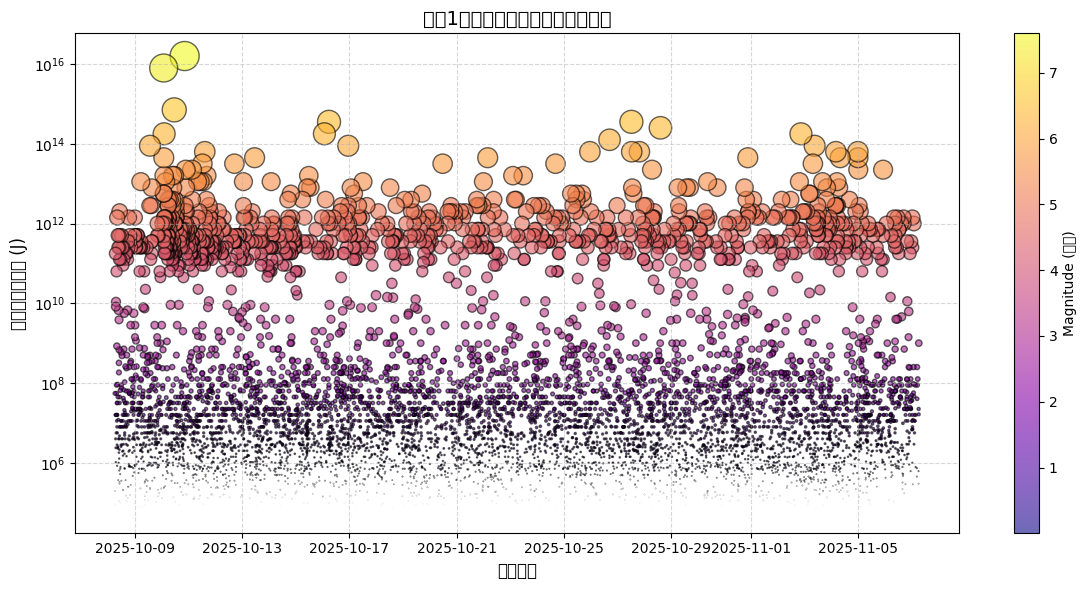

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.geojson"
data = requests.get(url).json()

records = []
for f in data["features"]:
    mag = f["properties"]["mag"]
    time = pd.to_datetime(f["properties"]["time"], unit="ms")
    depth = f["geometry"]["coordinates"][2]
    if mag and mag > 0:
        energy = 10 ** (1.5 * mag + 4.8)  
        records.append([time, mag, energy, depth])

df = pd.DataFrame(records, columns=["time", "mag", "energy", "depth"])


plt.figure(figsize=(12,6))
plt.scatter(df["time"], df["energy"], 
            c=df["mag"], s=df["mag"]**3, alpha=0.6, cmap="plasma", edgecolors="k")

plt.yscale("log")  
plt.colorbar(label="Magnitude (M)")
plt.title("energy_plot", fontsize=14)
plt.xlabel("time", fontsize=12)
plt.ylabel("energy(J)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()